<img src="https://github.com/vhertel/radar-based-flood-mapping/blob/main/resources/header.png?raw=1" width="1000"/>


# Radar-based Flood Mapping

<img src="https://github.com/vhertel/radar-based-flood-mapping/blob/main/resources/example.png?raw=1" width="1000"/>

***

The objective of this [Recommended Practice](https://un-spider.org/advisory-support/recommended-practices) is to determine the extent of flooded areas. The usage of Synthetic Aperture Radar (SAR) satellite imagery for flood extent mapping constitutes a viable solution with fast image processing, providing near real-time flood information to relief agencies for supporting humanitarian action. The high data reliability as well as the absence of geographical constraints, such as site accessibility, emphasize the technology’s potential in the field.

This Jupyter Notebook covers the full processing chain from data query and download up to the export of a final flood mask product by utilizing open access Sentinel-1 SAR data. The tool's workflow follows the UN-SPIDER Recommended Practice on [Radar-based Flood Mapping](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-radar-based-flood-mapping) and is illustrated in the chart below. After entering user specifications, Sentinel-1  data can directly be downloaded from the <a href="https://scihub.copernicus.eu/">Copernicus Open Access Hub</a>. Subsequently, the data is processed and stored in a variety of output formats.

<img src="https://github.com/vhertel/radar-based-flood-mapping/blob/main/resources/charts/chart0.png?raw=1" width="1000"/>

***

***File Structure***  
The Jupyter Notebook file constitutes the directory of origin. Additional data is contained in subfolders. Sentinel-1 images need to be stored in a subfolder called *'input'*. If no image is provided, the subfolder will automatically be created when accessing and downloading data from the <a href="https://scihub.copernicus.eu/">Copernicus Open Access Hub</a> through this tool. If an area of interest (AOI) file is available (supported formats: GeoJSON, SHP, KML, KMZ), it needs to be placed in a subfolder called *'AOI'*. If none are available, an interactive map will allow to manually draw the area of interest. For reasons of automatic file selection, it is recommended to place only one AOI file in the respective folder. However, if multiple files exist, GeoJSON files are prioritized followed by SHP, KML, and KMZ. The processed data is stored in a subfolder called *'output'*.  
In order to run the tool with no user interaction, all inputs must be clearly defined. This means that the *'input'* subfolder must include one single Sentinel-1 image and the *'AOI'* subfolder one single AOI file. All other scenarios do require manual interaction such as downloading data or defining an AOI.

***Limitations***  
Difficulties in detecting flooded vegetation and floods in urban areas due to double bounce backscatter. If water and non-water are very unequally distributed in the image, the histogram might not have a clear local minimum, leading to incorrect results in the automatic binarization process.


***Important***
The Jupyter Notebook takes advantage of the <a href="https://step.esa.int/docs/v6.0/apidoc/engine/">ESA SNAP API Engine</a> and requires installation of the SNAP-Python interface <i>snappy</i>. Click <a href="https://senbox.atlassian.net/wiki/spaces/SNAP/pages/24051781/Using+SNAP+in+your+Python+programs">here</a> for further information. Furthermore, the <a href="https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html">Jupyter Notebook Extensions</a> *Codefolding*, *ExecuteTime* and *Table of Contents (2)* are used for the most convene performance.

***

## User Input

<img src="https://github.com/vhertel/radar-based-flood-mapping/blob/main/resources/charts/chart1.png?raw=1" width="1000"/>

Please specify in the code cell below i) the polarisation to be processed, ii) whether data shall be downloaded from the <a href="https://scihub.copernicus.eu/">Copernicus Open Access Hub</a> with respective sensing period and login details, and iii) whether intermediate results should be plotted during the process.

In [1]:
# polarisations to be processed
polarisations = 'VH'                              # 'VH', 'VV', 'both'

# download image from Copernicus Open Access Hub
download = {
    'imageDownload'     : True,                   # 'True', 'False'
    'period_start'      : [2021, 7, 15],           # format: [Year, Month, Day]
    'period_stop'       : [2021, 7, 17],           # format: [Year, Month, Day]
    'username'          : 'jacopo_margutti',             # username for login
    'password'          : 'Room4Copernicus'              # password for login
}

# show intermediate results if set to 'True'
plotResoluts = True                               # 'True', 'False'

## Initialization

This section loads relevant Python modules for the following analysis and initializes basic functionalities.

In [2]:
# Click to run

#####################################################
###################### IMPORTS ######################
#####################################################

# MODULE                                      # DESCRIPTION
import sys
import matplotlib.pyplot as plt               # create visualizations
import numpy as np                            # scientific comupting
import json                                   # JSON encoder and decoder
import glob                                   # data access
import os                                     # data access
import ipywidgets                             # interactive UI controls
import time                                   # time assessment
import shutil                                 # file operations
import ipyleaflet                             # visualization
import geopandas                              # data analysis and manipulation
import snappy                                 # SNAP Python interface
import jpy                                    # Python-Java bridge
import skimage.filters                        # threshold calculation
import functools                              # higher-order functions and operations
from ipyfilechooser import FileChooser        # file chooser widget
from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt  # interface to Open Access Hub
from datetime import date                     # dates, times and intervalls
from IPython.display import display           # visualization
from osgeo import ogr, gdal, osr              # data conversion
from zipfile import ZipFile                   # file management

####################################################
############### FUNCTION DEFINITIONS ###############
####################################################

# Function looks for AOI file, converts to GeoJSON if not given and returns GeoJSON
def readJSONFromAOI(path):
    # check for GeoJSON file in 'AOI' subfolder
    if len(glob.glob('%s/*.geojson' % path)) == 1:
        file = glob.glob('%s/*.geojson' % path)[0]
    elif len(glob.glob('%s/*.json' % path)) == 1:
        file = glob.glob('%s/*.json' % path)[0]

    # convert SHP to GeoJSON if no JSON is given
    elif len(glob.glob('%s/*.shp' % path)) == 1:
        file_name = os.path.splitext(glob.glob('%s/*.shp' % path)[0])[0].split('/')[-1]
        shp_file = geopandas.read_file(glob.glob('%s/*.shp' % path)[0])
        shp_file.to_file('%s/%s.json' % (path, file_name), driver='GeoJSON')
        file = glob.glob('%s/*.json' % path)[0]

    # convert KML to GeoJSON if no JSON or SHP is given
    elif len(glob.glob('%s/*.kml' % path)) == 1:
        file_name = os.path.splitext(glob.glob('%s/*.kml' % path)[0])[0].split('/')[-1]
        kml_file = gdal.OpenEx(glob.glob('%s/*.kml' % path)[0])
        ds = gdal.VectorTranslate('%s/%s.json' % (path, file_name), kml_file, format='GeoJSON')
        del ds
        file = glob.glob('%s/*.json' % path)[0]

    # convert KMZ to JSON if no JSON, SHP, or KML is given
    elif len(glob.glob('%s/*.kmz' % path)) == 1:
        # open KMZ file and extract data
        with ZipFile(glob.glob('%s/*.kmz' % path)[0], 'r') as kmz:
            folder = os.path.splitext(glob.glob('%s/*.kmz' % path)[0])[0]
            kmz.extractall(folder)
        # convert KML to GeoJSON if extracted folder contains one KML file
        if len(glob.glob('%s/*.kml' % folder)) == 1:
            kml_file = gdal.OpenEx(glob.glob('%s/*.kml' % folder)[0])
            ds = gdal.VectorTranslate('%s/%s.json' % (path, folder.split('/')[-1]), kml_file, format='GeoJSON')
            del ds
            file = glob.glob('%s/*.json' % path)[0]
            # remove unzipped KMZ directory and data
            shutil.rmtree(folder)
    # allow to upload AOI file or manually draw AOI if no file was found
    else:
        raise FileNotFoundError

    # open JSON file and store data
    with open(file, 'r') as f:
        data_json = json.load(f)

    return data_json

# plot band and histogram of 'Band'-type input and threshold
# SNAP API: https://step.esa.int/docs/v6.0/apidoc/engine/
def plotBand(band, threshold, binary=False):
    # color stretch
    vmin, vmax = 0, 1
    # read pixel values
    w = band.getRasterWidth()
    h = band.getRasterHeight()
    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)
    band_data.shape = h, w
    # color stretch
    if binary:
        cmap = plt.get_cmap('binary')
    else:
        vmin = np.percentile(band_data, 2.5)
        vmax = np.percentile(band_data, 97.5)
        cmap = plt.get_cmap('gray')
    # plot band
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
    ax1.imshow(band_data, cmap=cmap, vmin=vmin, vmax=vmax)
    ax1.set_title(band.getName())
    # plot histogram
    band_data.shape = h * w 
    ax2.hist(np.asarray(band_data[band_data != 0], dtype='float'), bins=2048)
    ax2.axvline(x=threshold, color='r')
    ax2.set_title('Histogram: %s' % band.getName())
    
    for ax in fig.get_axes():
        ax.label_outer()




####################################################
####################### CODE #######################
####################################################   
        
# get current working directory
directory = os.getcwd()

print('done')

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Incompatible GDAL 3.2.2 found on system. Internal GDAL 3.0.0 from distribution will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.


done


## Download Image

<img src="https://github.com/vhertel/radar-based-flood-mapping/blob/main/resources/charts/chart2.png?raw=1" width="1000"/>

This section allows interactive data access and download from the <a href="https://scihub.copernicus.eu/">Copernicus Open Access Hub</a>. If an AOI file is given in the *'AOI'* subfolder, the tool searches and displays available Sentinel-1 images accordingly. If no AOI file is provided, the search bar on the left side of the interactive map can be used to find the desired region. The AOI can be then be selected and manipulated manually by using the drawing tool. Clicking the Search button below the map will load available images. If multiple AOIs are drawn, only the last one is considered. When hovering over a Sentinel-1 image, the tile index and ingestion date are shown. The table below summarizes information on all available tiles and allows the download. The data is stored in the automatically created *'input'* subfolder. The Open Access Hub maintains an online archive of at least the latest year of products for immediate download. Access to previous products that are no longer available online will automatically trigger the retrieval from the long term archives. The actual download can be initiated by the user once the data are restored (within 24 hours).

In [3]:
# Click to run
#date formates
#date=('20151219', date(2015, 12, 29)),
#daterange=('NOW-30DAYS', 'NOW')
#daterange = ('20211011', '20211016')
####################################################
############### FUNCTION DEFINITIONS ###############
####################################################

# search for and display available Sentinel-1 tiles
def queri(footprint):
    # print status
    print('Loading...', flush=True)
    # search Copernicus Open Access Hub for products with regard to input footprint and sensing period
    try:
        products = api.query(footprint,
                             #date=daterange,
                             date = (date(download['period_start'][0], download['period_start'][1], download['period_start'][2]),
                                     date(download['period_stop'][0], download['period_stop'][1], download['period_stop'][2])),
                             platformname = 'Sentinel-1',
                             producttype = 'GRD')

        print('Successfully connected to Copernicus Open Access Hub.\n', flush=True)
    except:
        sys.exit('\nLogin data not valid. Please change username and/or password.')
    # convert to GeoJSON for plot
    products_json = api.to_geojson(products)
    # raise warning that no image is available in given sensing period
    if not products_json['features']:
        sys.exit('\nNo Sentinel-1 images available. Please change sensing period in user input section.')
    # convert to dataframe for table visualization
    products_df = api.to_dataframe(products).sort_values('ingestiondate', ascending=[False])
    # adds index to dataframe
    indices = []
    for i in range (1, len(products_df.index)+1):
        indices.append('Tile %d' % i)
        products_json.features[i-1].properties['index'] = ' Tile %d' % i
    products_df.insert(0, 'index', indices, True) 
    # plot available Sentinel-1 tiles
    geo_json = ipyleaflet.GeoJSON(data = products_json,
                                  name = 'S1 tiles',
                                  style = {'color' : 'royalblue'},
                                  hover_style = {'fillOpacity' : 0.4})
    download_map.add_layer(geo_json)
    # call click_handler function when user clicks on Sentinel-1 tile
    tile_ID = geo_json.on_hover(hover_handler)
    # print table with download buttons
    grid = ipywidgets.GridspecLayout(len(products_df.index)+1, 5)
    grid[0,0] = ipywidgets.HTML('<h4>Index</h4>')
    grid[0,1] = ipywidgets.HTML('<h4>Date</h4>')
    grid[0,2] = ipywidgets.HTML('<h4>Polarisation</h4>')
    grid[0,3] = ipywidgets.HTML('<h4>Size</h4>')
    for i in range(len(products_df.index)):
        grid[i+1,0] = ipywidgets.Label(products_df['index'][i])
        grid[i+1,1] = ipywidgets.Label(str(products_df['beginposition'][i]))
        grid[i+1,2] = ipywidgets.Label(products_df['polarisationmode'][i])
        grid[i+1,3] = ipywidgets.Label(products_df['size'][i])
        grid[i+1,4] = ipywidgets.Button(description = 'Download')
        grid[i+1,4].on_click(functools.partial(on_downloadButton_clicked, tile_id=products_df.values[i][-1]))
        print('productIDs    ' + products_df.values[i][-1])
    display(grid)
    
    
# show product index and date on HTML element when hovering on Sentinel-1 tile 
def hover_handler(feature, **kwargs):
    # reset HTML widget and set new values
    html.value = '''
    Index: {}<br/>
    <small>Date: {}</small>
    '''.format(feature['properties']['index'], feature['properties']['beginposition'])

# search for available Sentinel-1 tiles with regard to AOI
def on_searchButton_clicked(b):
    # refocus of map to cover Sentinel-1 tiles
    download_map.zoom = 6.5
    # create WKT element with geographic coordinates of AOI
    coordinates = draw_control.last_draw['geometry']['coordinates'][0]
    lng1, lat1 = coordinates[0][0], coordinates[0][1]
    lng2, lat2 = coordinates[1][0], coordinates[1][1]
    lng3, lat3 = coordinates[2][0], coordinates[2][1]
    lng4, lat4 = coordinates[3][0], coordinates[3][1]
    footprint = 'POLYGON((%s %s, %s %s, %s %s, %s %s, %s %s))' % (lng1, lat1, lng2, lat2, lng3, lat3, lng4, lat4, lng1, lat1)
    # call function to search for available Sentinel-1 tiles
    queri(footprint)
    
# download chosen Sentinel-1 tile in subfolder 'input'
def on_downloadButton_clicked(b, tile_id):
    print('clicked')
    # get product information
    product_info = api.get_product_odata(tile_id)
    # check whether product is available
    if product_info['Online']:
        # check if input folder exists, if not create input folder
        input_path = os.path.join(directory, 'input')
        if not os.path.isdir(input_path):
            os.mkdir(input_path)
        # change into 'input' subfolder for storing product
        os.chdir(input_path)
        # status update
        print('\nProduct %s is online. Starting download.' % tile_id, flush=True)
        # download product
        api.download(tile_id)
        # change back to previous working directory
        os.chdir(directory)
    # error message when product is not available
    else:
        print('\nProduct %s is not online. Must be requested manually.\n' % tile_id, flush=True)




####################################################
####################### CODE #######################
####################################################

# check user input whether image download is requested
if download['imageDownload']:
    # connect to the API
    api = SentinelAPI(download['username'], download['password'], 'https://scihub.copernicus.eu/dhus')
    # create map with search functionality
    download_map = ipyleaflet.Map(zoom = 1.4)
    download_map.add_control(ipyleaflet.SearchControl(
        position = 'topleft',
        url = 'https://nominatim.openstreetmap.org/search?format=json&q={s}',
        zoom = 5))
    download_map.add_control(ipyleaflet.ScaleControl(position='bottomleft'))
    display(download_map)
    
    # create HTML widget to display product index and date of selected Sentinel-1 tile
    html = ipywidgets.HTML('')
    control = ipyleaflet.WidgetControl(widget=html, position='topright')
    download_map.add_control(control)
    
    # check whether AOI file is given and convert to JSON in order to show AOI on map
    try:
        # calls readJSONfromAOI function to get GeoJSON from either JSON, SHP, or KMZ file
        data_json = readJSONFromAOI('%s/AOI' % directory)
        # show AOI on map according to JSON data
        aoi = ipyleaflet.GeoJSON(data = data_json, style = {'color' : 'green'})
        download_map.zoom = 6.5
        try:
            # GeoJSON format if KMZ is given
            download_map.center = (aoi.data['features'][0]['geometry']['coordinates'][0][0][0][1],
                                   aoi.data['features'][0]['geometry']['coordinates'][0][0][0][0])
        except:
            # GeoJSON format if JSON or SHP is given
            download_map.center = (aoi.data['features'][0]['geometry']['coordinates'][0][0][1],
                                   aoi.data['features'][0]['geometry']['coordinates'][0][0][0])
        download_map.add_layer(aoi)
        # search for available Sentinel-1 tiles according to JSON data
        footprint = geojson_to_wkt(data_json)
        queri(footprint)

    # if no AOI is given, it needs to be selected manually
    except FileNotFoundError:
        # create draw control function
        draw_control = ipyleaflet.DrawControl(circlemarker={},
                                              polyline={},
                                              polygon={'shapeOptions':{'color':'green'}},
                                              rectangle={'shapeOptions':{'color':'green'}})
        # adds draw control function to map
        download_map.add_control(draw_control)
        # create search button and call function to search for available Sentinel-1 tiles when clicked
        searchButton = ipywidgets.Button(description = 'Search')
        searchButton.on_click(on_searchButton_clicked)
        display(searchButton)
        
print('done')

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Loading...
Successfully connected to Copernicus Open Access Hub.

productIDs    6a326d50-02ab-481f-b76a-c3974f78a96b
productIDs    75c5c98e-b2da-4c62-93bf-88442843c462


GridspecLayout(children=(HTML(value='<h4>Index</h4>', layout=Layout(grid_area='widget001')), HTML(value='<h4>D…

done


In [5]:
### ! choose the correct tile id from productIDs ###
tile_id = '6a326d50-02ab-481f-b76a-c3974f78a96b' # it needs to be the product id

# get product information
product_info = api.get_product_odata(tile_id)
# check whether product is available
if product_info['Online']:
    # check if input folder exists, if not create input folder
    input_path = os.path.join(directory, 'input')
    if not os.path.isdir(input_path):
        os.mkdir(input_path)
    # change into 'input' subfolder for storing product
    os.chdir(input_path)
    # status update
    print('\nProduct %s is online. Starting download.' % tile_id, flush=True)
    # download product
    api.download(tile_id)
    # change back to previous working directory
    os.chdir(directory)
# error message when product is not available
else:
    print('\nProduct %s is not online. Must be requested manually.\n' % tile_id, flush=True)
    
print('done')


Product 6a326d50-02ab-481f-b76a-c3974f78a96b is online. Starting download.


KeyboardInterrupt: 

## Processing

<img src="https://github.com/vhertel/radar-based-flood-mapping/blob/main/resources/charts/chart3.png?raw=1" width="1000"/>

If more than one Sentinel-1 image exists in the *'input'* subfolder, the user can select which one is to be used for the processing. The subset is generated according to the AOI file in the *'AOI'* subfolder. If no AOI file is provided, an interactive map allows drawing the area of interest. Subsequently, the following processing steps are performed:

1. ***Apply Orbit File***: The orbit file provides accurate satellite position and velocity information. Based on this information, the orbit state vectors in the abstract metadata of the product are updated. The precise orbit files are available days-to-weeks after the generation of the product. Since this is an optional processing step, the tool will continue the workflow in case the orbit file is not yet available to allow rapid mapping applications.


2. ***Thermal Noise Removal***: Thermal noise correction is applied to Sentinel-1 Level-1 GRD products which have not already been corrected.


3. ***Radiometric Calibration***: The objective of SAR calibration is to provide imagery in which the pixel values can be directly related to the radar backscatter of the scene. Though uncalibrated SAR imagery is sufficient for qualitative use, calibrated SAR images are essential to the quantitative use of SAR data.


4. ***Speckle Filtering***: SAR images have inherent texturing called speckles which degrade the quality of the image and make interpretation of features more difficult. Speckles are caused by random constructive and destructive interference of the de-phased but coherent return waves scattered by the elementary scatter within each resolution cell. Speckle noise reduction can be applied either by spatial filtering or multilook processing. A Lee filter with an X, Y size of 5, 5 is used in this step.


5. ***Terrain Correction***: Due to topographical variations of a scene and the tilt of the satellite sensor, distances can be distorted in the SAR images. Data which is not directly directed towards the sensor’s Nadir location will have some distortion. Therefore, terrain corrections are intended to compensate for these distortions to allow a realistic geometric representation in the image.


6. ***Binarization***: In order to obtain a binary flood mask, the histogram is analyzed to separate water from non-water pixels. Due to the side-looking geometry of SAR sensors and the comparably smooth surface of water, only a very small proportion of backscatter is reflected back to the sensor leading to comparably low pixel values in the histogram. The threshold used for separation is automatically calculated using <a href="https://scikit-image.org/">scikit-image</a> implementations and a combined use of the <a href="https://doi.org/10.1111/j.1749-6632.1965.tb11715.x">minimum method</a> and <a href="https://www.semanticscholar.org/paper/A-threshold-selection-method-from-gray-level-Otsu/1d4816c612e38dac86f2149af667a5581686cdef?p2df">Otsu's method</a>. The <a href="http://due.esrin.esa.int/page_globcover.php">GlobCover</a> layer of the European Space Agency is used to mask out permanent water bodies.


7. ***Speckle Filtering***: A Median filter with an X, Y size of 7, 7 is used in this step.

Selected:  S1A_IW_GRDH_1SDV_20210715T055052_20210715T055117_038784_049389_2074.zip



<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_80/2852279523.py:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(files) is 1:
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.


Map(center=[50.18015565289524, 5.367803602349195], controls=(ZoomControl(options=['position', 'zoom_in_text', …


Subset successfully generated.


1. Apply Orbit File:          100% done.


INFO: org.hsqldb.persist.Logger: dataFileCache open start


OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2021-07-01T00:00:000Z TO 2021-07-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2021-08-01T00:00:000Z TO 2021-08-31T24:00:000Z]
OpenSearch: 70 total results on 1 pages.
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2021-08-01T00:00:000Z TO 2021-08-31T24:00:000Z]

100% done.
--- 1.78  seconds ---
2. Thermal Noise Removal:     
100% done.
--- 0.09  seconds ---
3. Radiometric Calibration:   

Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /srv/conda/envs/env_snap/snap/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2021/07
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /srv/conda/envs/env_snap/snap/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2021/07



100% done.
--- 0.18  seconds ---
4. Speckle Filtering:         
100% done.
--- 0.04  seconds ---

100% done.
5. Terrain Correction:        
100% done.
--- 0.29  seconds ---
6. Binarization:              
50%100% done.
--- 12.96 seconds ---

7. Speckle Filtering:         100% done.

100% done.
--- 0.02  seconds ---
8. Plot:                      --- 39.17 seconds ---
done


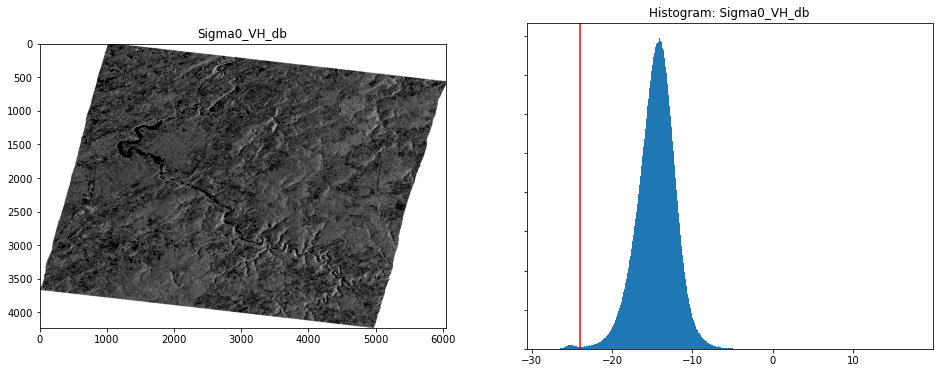

In [6]:
# Click to run

####################################################
############### FUNCTION DEFINITIONS ###############
####################################################

# create S1 product
def getScene(path):
    # set correct path of input file and create S1 product
    if len(files) is 1:
        file_path = path
    else:
        file_path = path.selected
    S1_source = snappy.ProductIO.readProduct(file_path)

    # read geographic coordinates from Sentinel-1 image meta data
    meta_data = S1_source.getMetadataRoot().getElement('Abstracted_Metadata')
    # refines center of map according to Sentinel-1 image
    center = (meta_data.getAttributeDouble('centre_lat'), meta_data.getAttributeDouble('centre_lon'))
    locations = [[{'lat' : meta_data.getAttributeDouble('first_near_lat'), 'lng' : meta_data.getAttributeDouble('first_near_long')},
                  {'lat' : meta_data.getAttributeDouble('last_near_lat'),  'lng' : meta_data.getAttributeDouble('last_near_long')},
                  {'lat' : meta_data.getAttributeDouble('last_far_lat'),   'lng' : meta_data.getAttributeDouble('last_far_long')},
                  {'lat' : meta_data.getAttributeDouble('first_far_lat'),  'lng' : meta_data.getAttributeDouble('first_far_long')}]]

    # creates interactive map
    basic_map = ipyleaflet.Map(center = center, zoom = 7.5)
    # defines fixed polygon illustrating Sentinel-1 image
    polygon_fix = ipyleaflet.Polygon(locations = locations, color='royalblue')
    basic_map.add_layer(polygon_fix)
    # displays map
    basic_map.add_control(ipyleaflet.ScaleControl(position='bottomleft'))
    display(basic_map)
    
    # check whether AOI file is given and convert to JSON in order to show AOI on map
    try:
        # calls readJSONfromAOI function to get GeoJSON from either JSON, SHP, or KMZ file
        data_json = readJSONFromAOI('%s/AOI' % directory)
        # show AOI on map according to JSON data
        basic_map.add_layer(ipyleaflet.GeoJSON(data = data_json, style = {'color' : 'green'}))
        # apply subset according to JSON data
        footprint = geojson_to_wkt(data_json)
        # run processing process
        processing(S1_source, footprint)
        
    # if no AOI is given, it needs to be selected manually
    except:
        # editable polygon determining AOI
        polygon_flex = ipyleaflet.Polygon(locations = locations,
                                          color = 'green',
                                          fill_color = 'green',
                                          transform = True)
        basic_map.add_layer(polygon_flex)
        # create process button and call function to start ptocessing when clicked
        processButton = ipywidgets.Button(description = 'Start Processing')
        processButton.on_click(functools.partial(on_processButton_clicked,
                                                 S1_source = S1_source,
                                                 polygon_flex = polygon_flex))
        display(processButton)
    
# calculate and return threshold of 'Band'-type input
# SNAP API: https://step.esa.int/docs/v6.0/apidoc/engine/
def getThreshold(S1_band):
    # read band
    w = S1_band.getRasterWidth()
    h = S1_band.getRasterHeight()
    band_data = np.zeros(w * h, np.float32)
    S1_band.readPixels(0, 0, w, h, band_data)
    band_data.shape = h * w

    # calculate threshold using Otsu method
    threshold_otsu = skimage.filters.threshold_otsu(band_data)
    # calculate threshold using minimum method
    threshold_minimum = skimage.filters.threshold_minimum(band_data)
    # get number of pixels for both thresholds
    numPixOtsu = len(band_data[abs(band_data - threshold_otsu) < 0.1])
    numPixMinimum = len(band_data[abs(band_data - threshold_minimum) < 0.1])

    # if number of pixels at minimum threshold is less than 1% of number of pixels at Otsu threshold
    if abs(numPixMinimum/numPixOtsu) < 0.001:
        # adjust band data according
        if threshold_otsu < threshold_minimum:
            band_data = band_data[band_data < threshold_minimum]
            threshold_minimum = skimage.filters.threshold_minimum(band_data)
        else:
            band_data = band_data[band_data > threshold_minimum]
            threshold_minimum = skimage.filters.threshold_minimum(band_data)
    
        numPixMinimum = len(band_data[abs(band_data - threshold_minimum) < 0.1])

    # select final threshold
    if abs(numPixMinimum/numPixOtsu) < 0.001:
        threshold = threshold_otsu
    else:
        threshold = threshold_minimum

    return threshold

# calculate binary mask of 'Product'-type intput with respect expression in string array
def binarization(S1_product, expressions):

    BandDescriptor = jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')
    targetBands = jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', len(expressions))

    # loop through bands
    for i in range(len(expressions)):
        targetBand = BandDescriptor()
        targetBand.name = '%s' % S1_product.getBandNames()[i]
        targetBand.type = 'float32'
        targetBand.expression = expressions[i]
        targetBands[i] = targetBand
    
    parameters = snappy.HashMap()
    parameters.put('targetBands', targetBands)    
    mask = snappy.GPF.createProduct('BandMaths', parameters, S1_product)

    return mask

# start processing button 
def on_processButton_clicked(b, S1_source, polygon_flex):
    # get coordinates and store in WKT format variable
    lng1, lat1 = polygon_flex.locations[0][0]['lng'], polygon_flex.locations[0][0]['lat']
    lng2, lat2 = polygon_flex.locations[0][1]['lng'], polygon_flex.locations[0][1]['lat']
    lng3, lat3 = polygon_flex.locations[0][2]['lng'], polygon_flex.locations[0][2]['lat']
    lng4, lat4 = polygon_flex.locations[0][3]['lng'], polygon_flex.locations[0][3]['lat']
    footprint = 'POLYGON((%s %s, %s %s, %s %s, %s %s, %s %s))' % (lng1, lat1, lng2, lat2, lng3, lat3, lng4, lat4, lng1, lat1)
    # run processing
    processing(S1_source, footprint)

# processing steps
def processing(S1_source, footprint):
    
    # Subset operator
    parameters = snappy.HashMap()
    parameters.put('copyMetadata', True)
    geom = snappy.WKTReader().read(footprint)
    parameters.put('geoRegion', geom)
    parameters.put('sourceBands', sourceBands)
    S1_crop = snappy.GPF.createProduct('Subset', parameters, S1_source)
    # status update
    print('\nSubset successfully generated.\n', flush=True)
    
    # Apply-Orbit-File operator
    print('1. Apply Orbit File:          ', end='', flush=True)
    start_time = time.time()
    parameters = snappy.HashMap()
    # continue with calculation in case no orbit file is available yet
    parameters.put('continueOnFail', True)
    S1_Orb = snappy.GPF.createProduct('Apply-Orbit-File', parameters, S1_crop)
    print('--- %.2f  seconds ---' % (time.time() - start_time), flush=True)

    # ThermalNoiseRemoval operator
    print('2. Thermal Noise Removal:     ', end='', flush=True)
    start_time = time.time()
    parameters = snappy.HashMap()
    parameters.put('removeThermalNoise', True)
    S1_Thm = snappy.GPF.createProduct('ThermalNoiseRemoval', parameters, S1_Orb)
    print('--- %.2f  seconds ---' % (time.time() - start_time), flush=True)

    # Calibration operator
    print('3. Radiometric Calibration:   ', end='', flush=True)
    start_time = time.time()
    parameters = snappy.HashMap()
    parameters.put('outputSigmaBand', True)
    S1_Cal = snappy.GPF.createProduct('Calibration', parameters, S1_Thm)
    print('--- %.2f  seconds ---' % (time.time() - start_time), flush=True)

    # Speckle-Filter operator
    print('4. Speckle Filtering:         ', end='', flush=True)
    start_time = time.time()
    parameters = snappy.HashMap()
    parameters.put('filter', 'Lee')
    parameters.put('filterSizeX', 5)
    parameters.put('filterSizeY', 5)
    S1_Spk = snappy.GPF.createProduct('Speckle-Filter', parameters, S1_Cal)
    print('--- %.2f  seconds ---' % (time.time() - start_time), flush=True)

    # Conversion from linear to db operator
    S1_Spk_db = snappy.GPF.createProduct('LinearToFromdB', snappy.HashMap(), S1_Spk)

    # Terrain-Correction operator
    print('5. Terrain Correction:        ', end='', flush=True)
    parameters = snappy.HashMap()
    parameters.put('demName', 'SRTM 1Sec HGT')
    parameters.put('demResamplingMethod', 'BILINEAR_INTERPOLATION')
    parameters.put('imgResamplingMethod', 'NEAREST_NEIGHBOUR')
    parameters.put('pixelSpacingInMeter', 10.0)
    parameters.put('nodataValueAtSea', False)
    parameters.put('saveSelectedSourceBand', True)
    S1_TC = snappy.GPF.createProduct('Terrain-Correction', parameters, S1_Spk_db)
    print('--- %.2f  seconds ---' % (time.time() - start_time), flush=True)

    # Binarization
    print('6. Binarization:              ', end='', flush=True)
    start_time = time.time()
    # add GlobCover band
    parameters = snappy.HashMap()
    parameters.put('landCoverNames', 'GlobCover')
    GlobCover = snappy.GPF.createProduct('AddLandCover', parameters, S1_TC)
    # empty string array for binarization band maths expression(s)
    expressions = ['' for i in range(S1_TC.getNumBands())]
    # empty array for threshold(s)
    thresholds = np.zeros(S1_TC.getNumBands())
    # loop through bands
    for i in range(S1_TC.getNumBands()):
        # calculate threshold of band and store in float array
        # use S1_Spk_db product for performance reasons. S1_TC causes 0-values
        # which distort histogram and thus threshold result
        thresholds[i] = getThreshold(S1_Spk_db.getBandAt(i))
        # formulate expression according to threshold and store in string array
        expressions[i] = 'if (%s < %s && land_cover_GlobCover != 210) then 1 else NaN' % (S1_TC.getBandNames()[i], thresholds[i])
    # do binarization
    S1_floodMask = binarization(GlobCover, expressions)
    print('--- %.2f seconds ---' % (time.time() - start_time), flush=True)

    # Speckle-Filter operator
    print('7. Speckle Filtering:         ', end='', flush=True)
    start_time = time.time()
    parameters = snappy.HashMap()
    parameters.put('filter', 'Median')
    parameters.put('filterSizeX', 5)
    parameters.put('filterSizeY', 5)
    # define flood mask as global for later access
    global S1_floodMask_Spk
    S1_floodMask_Spk = snappy.GPF.createProduct('Speckle-Filter', parameters, S1_floodMask)
    print('--- %.2f  seconds ---' % (time.time() - start_time), flush=True)

    # output
    if plotResoluts:
        print('8. Plot:                      ', end='', flush=True)
        start_time = time.time()
        for i in range(S1_TC.getNumBands()):
            plotBand(S1_TC.getBandAt(i), thresholds[i])
        print('--- %.2f seconds ---' % (time.time() - start_time), flush=True)




####################################################
####################### CODE #######################
####################################################

# filter required polarisation(s) and set output file name accordingly
if polarisations == 'both':
    sourceBands = 'Amplitude_VH,Intensity_VH,Amplitude_VV,Intensity_VV'
    output_extensions   = 'processed_VHVV'
elif polarisations == 'VH':
    sourceBands = 'Amplitude_VH,Intensity_VH'
    output_extensions   = 'processed_VH'
elif polarisations == 'VV':
    sourceBands = 'Amplitude_VV,Intensity_VV'
    output_extensions   = 'processed_VV'

# path of Sentinel-1 .zip input file
input_path = os.path.join(directory, 'input')
# empty string array to store Sentinel-1 files in 'input' subfolder
files = []
# add files to list
for file in glob.glob1(input_path, '*.zip'):
    files.append(file)
# select input file and start processing if there is only one available Sentinel-1 file
if len(files) == 1:
    input_name = files[0]
    print('Selected:  %s\n' % input_name, flush=True)
    # apply subset according to JSON data
    getScene('%s/%s' % (input_path, input_name))
# open dialogue to select input file if more or less than one is available
else:
    print('More or less than one Sentinel-1 files have been found. Please select.', flush=True)
    fc = FileChooser(input_path)
    fc.filter_pattern = '*.zip'
    fc.register_callback(getScene)
    display(fc)
        
print('done')

## Data Export

<img src="https://github.com/vhertel/radar-based-flood-mapping/blob/main/resources/charts/chart4.png?raw=1" width="1000"/>

The processed flood mask is exported as GeoTIFF, SHP, KML, and GeoJSON and stored in the *'output'* subfolder. An interactive map shows the flood mask.

In [ ]:
# Click to run

####################################################
####################### CODE #######################
####################################################

print('Exporting...\n', flush=True)
# check if output folders exists, if not create folders
output_path = os.path.join(directory, 'output')
if not os.path.isdir(output_path):
    os.mkdir(output_path)
GeoTIFF_path = os.path.join(output_path, 'GeoTIFF')
if not os.path.isdir(GeoTIFF_path):
    os.mkdir(GeoTIFF_path)
SHP_path = os.path.join(output_path, 'SHP')
if not os.path.isdir(SHP_path):
    os.mkdir(SHP_path)
KML_path = os.path.join(output_path, 'KML')
if not os.path.isdir(KML_path):
    os.mkdir(KML_path)
GeoJSON_path = os.path.join(output_path, 'GeoJSON')
if not os.path.isdir(GeoJSON_path):
    os.mkdir(GeoJSON_path)
# get file name if file chooser was used
if len(files) is not 1: input_name = fc.selected_filename

# write output file as GeoTIFF
print('1. GeoTIFF:                   ', end='', flush=True)
start_time = time.time()
snappy.ProductIO.writeProduct(S1_floodMask_Spk, '%s/%s_%s' % (GeoTIFF_path, os.path.splitext(input_name)[0], output_extensions), 'GeoTIFF')
print('--- %.2f seconds ---' % (time.time() - start_time), flush=True)

# convert GeoTIFF to SHP
print('2. SHP:                       ', end='', flush=True)
start_time = time.time()
# allow GDAL to throw Python exceptions
gdal.UseExceptions()
open_image = gdal.Open('%s/%s_%s.tif' % (GeoTIFF_path, os.path.splitext(input_name)[0], output_extensions))
srs = osr.SpatialReference()
srs.ImportFromWkt(open_image.GetProjectionRef())
shp_driver = ogr.GetDriverByName('ESRI Shapefile')
# empty string array for bands in GeoTIFF
output_shp = ['' for i in range(open_image.RasterCount)]
if open_image.RasterCount == 1:
    output_shp[0] = '%s/%s_processed_%s' % (SHP_path, os.path.splitext(input_name)[0], polarisations)
else:
    VH_SHP_path = os.path.join(SHP_path, 'VH')
    if not os.path.isdir(VH_SHP_path):
        os.mkdir(VH_SHP_path)
    VV_SHP_path = os.path.join(SHP_path, 'VV')
    if not os.path.isdir(VV_SHP_path):
        os.mkdir(VV_SHP_path)
    output_shp[0] = '%s/%s_processed_VH' % (VH_SHP_path, os.path.splitext(input_name)[0])
    output_shp[1] = '%s/%s_processed_VV' % (VV_SHP_path, os.path.splitext(input_name)[0])
# loops through bands in GeoTIFF
for i in range(open_image.RasterCount):
    input_band = open_image.GetRasterBand(i+1)
    output_shapefile = shp_driver.CreateDataSource(output_shp[i] + '.shp')
    new_shapefile = output_shapefile.CreateLayer(output_shp[i], srs=srs)
    new_shapefile.CreateField(ogr.FieldDefn('DN', ogr.OFTInteger))
    gdal.Polygonize(input_band, input_band.GetMaskBand(), new_shapefile, 0, [], callback=None)
    # filters attributes with values other than 1 (sould be NaN or respective value)
    new_shapefile.SetAttributeFilter('DN != 1')
    for feat in new_shapefile:
        new_shapefile.DeleteFeature(feat.GetFID())
    new_shapefile.SyncToDisk()
print('--- %.2f seconds ---' % (time.time() - start_time), flush=True)

# convert SHP to KML
print('3. KML:                       ', end='', flush=True)
start_time = time.time()
if open_image.RasterCount == 1:
    shp_file = gdal.OpenEx('%s/%s_processed_%s.shp' % (SHP_path, os.path.splitext(input_name)[0], polarisations))
    ds = gdal.VectorTranslate('%s/%s_processed_%s.kml' % (KML_path, os.path.splitext(input_name)[0], polarisations), shp_file, format='KML')
    del ds
else:
    shp_file_VH = gdal.OpenEx('%s/%s_processed_VH.shp' % (VH_SHP_path, os.path.splitext(input_name)[0]))
    ds_VH = gdal.VectorTranslate('%s/%s_processed_VH.kml' % (KML_path, os.path.splitext(input_name)[0]), shp_file_VH, format='KML')
    del ds_VH
    shp_file_VV = gdal.OpenEx('%s/%s_processed_VV.shp' % (VV_SHP_path, os.path.splitext(input_name)[0]))
    ds_VV = gdal.VectorTranslate('%s/%s_processed_VV.kml' % (KML_path, os.path.splitext(input_name)[0]), shp_file_VV, format='KML')
    del ds_VV
print('--- %.2f seconds ---' % (time.time() - start_time), flush=True)

# convert SHP to GeoJSON
print('4. GeoJSON:                   ', end='', flush=True)
start_time = time.time()
if open_image.RasterCount == 1:
    shp_file = geopandas.read_file('%s/%s_processed_%s.shp' % (SHP_path, os.path.splitext(input_name)[0], polarisations))
    shp_file.to_file('%s/%s_processed_%s.json' % (GeoJSON_path, os.path.splitext(input_name)[0], polarisations), driver='GeoJSON')
else:
    shp_file_VH = geopandas.read_file('%s/%s_processed_VH.shp' % (VH_SHP_path, os.path.splitext(input_name)[0]))
    shp_file_VH.to_file('%s/%s_processed_VH.json' % (GeoJSON_path, os.path.splitext(input_name)[0]), driver='GeoJSON')    
    shp_file_VV = geopandas.read_file('%s/%s_processed_VV.shp' % (VV_SHP_path, os.path.splitext(input_name)[0]))
    shp_file_VV.to_file('%s/%s_processed_VV.json' % (GeoJSON_path, os.path.splitext(input_name)[0]), driver='GeoJSON')
print('--- %.2f seconds ---\n' % (time.time() - start_time), flush=True)
print('Files successfuly stored under %s.\n' % output_path, flush=True)

# plot results
results_map = ipyleaflet.Map(zoom=9, basemap=ipyleaflet.basemaps.OpenStreetMap.Mapnik)    
if open_image.RasterCount == 1:
    file = '%s/%s_processed_%s.json' % (GeoJSON_path, os.path.splitext(input_name)[0], polarisations)
    with open(file, 'r') as f:
        data_json = json.load(f) 
    mask = ipyleaflet.GeoJSON(data = data_json, name = 'Flood Mask', style = {'color':'blue', 'opacity':'1', 'fillColor':'blue', 'fillOpacity':'1', 'weight':'0.8'})
    results_map.add_layer(mask)
    results_map.center = (mask.data['features'][0]['geometry']['coordinates'][0][0][1],
                          mask.data['features'][0]['geometry']['coordinates'][0][0][0])
else:
    file_VV = '%s/%s_processed_VV.json' % (GeoJSON_path, os.path.splitext(input_name)[0])
    with open(file_VV, 'r') as f_VV:
        data_json_VV = json.load(f_VV)
    mask_VV = ipyleaflet.GeoJSON(data = data_json_VV, name = 'Flood Mask: VV', style = {'color':'red', 'opacity':'1', 'fillColor':'red', 'fillOpacity':'1', 'weight':'0.8'})
    results_map.add_layer(mask_VV)
    results_map.center = (mask_VV.data['features'][0]['geometry']['coordinates'][0][0][1],
                          mask_VV.data['features'][0]['geometry']['coordinates'][0][0][0])  
    file_VH = '%s/%s_processed_VH.json' % (GeoJSON_path, os.path.splitext(input_name)[0])
    with open(file_VH, 'r') as f_VH:
        data_json_VH = json.load(f_VH)
    mask_VH = ipyleaflet.GeoJSON(data = data_json_VH, name = 'Flood Mask: VH', style = {'color':'blue', 'opacity':'1', 'fillColor':'blue', 'fillOpacity':'1', 'weight':'0.8'})
    results_map.add_layer(mask_VH)
results_map.add_control(ipyleaflet.FullScreenControl())
results_map.add_control(ipyleaflet.LayersControl(position='topright'))
results_map.add_control(ipyleaflet.ScaleControl(position='bottomleft'))
display(results_map)

print('done')

Exporting...

